Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - loss: 0.6405 - val_loss: 0.0782
Epoch 2/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - loss: 0.1888 - val_loss: 0.0685
Epoch 3/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - loss: 0.1328 - val_loss: 0.0583
Epoch 4/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - loss: 0.0922 - val_loss: 0.0423
Epoch 5/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - loss: 0.0625 - val_loss: 0.0281
Epoch 6/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - loss: 0.0429 - val_loss: 0.0150
Epoch 7/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - loss: 0.0310 - val_loss: 0.0103
Epoch 8/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 125ms/step - loss: 0.0255 - val_loss: 0.0086
Epoch 9/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - loss: 0.0210 - val_loss: 0.0067
Epoch 10/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - loss: 0.0193 - val_loss: 0.0061
Epoch 11/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - loss: 0.0178 - val_loss: 0.0061
Epoch 12/25
215/215 ━━━━━━━━━━

/var/folders/dh/j5bmpt9d6clgh4sxgj75h9zh0000gn/T/ipykernel_64547/1181513062.py:111: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1),


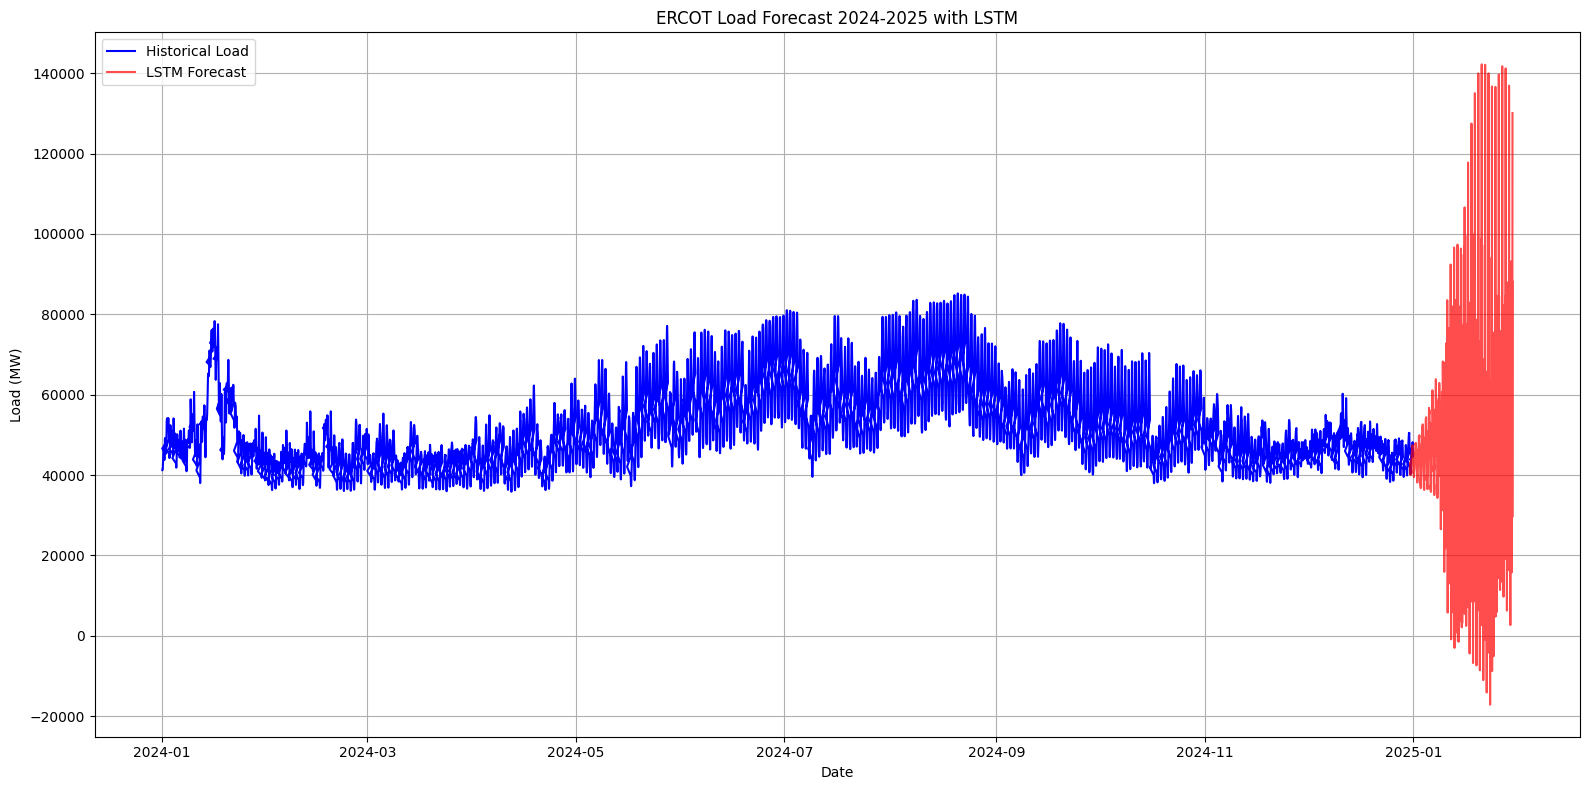

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os


path = os.getcwd()
# Load and preprocess data
df = pd.read_excel(path + "/Native_Load_2024.xlsx")

# Drop na rows
df.dropna(inplace=True)

# Clean and convert datetime
df['Hour Ending'] = (df['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df['Hour Ending'] = pd.to_datetime(df['Hour Ending'], format='%m/%d/%Y %H:%M')
df.set_index('Hour Ending', inplace=True)
load_series = df['ERCOT'].astype(float)

# Feature engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['ERCOT', 'hour', 'dayofweek']])

# Create sequences with 168-hour (7-day) lookback and 24-hour forecast
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data)-lookback-forecast_horizon):
        X.append(data[i:(i+lookback)])
        y.append(data[(i+lookback):(i+lookback+forecast_horizon), 0])
    return np.array(X), np.array(y)

LOOKBACK = 168  # 7 days of hourly data
FORECAST = 24   # Predict next 24 hours
X, y = create_sequences(scaled_data, LOOKBACK, FORECAST)

# Split dataset
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(LOOKBACK, X.shape[2])))
model.add(BatchNormalization()) # Add Batch Normalization to stabilize training
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(FORECAST))
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse') # Adjust learning rate to 0.0001

# Removed the line that clips the learning rate as it is not needed

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Add early stopping to prevent overfitting

# Train model
history = model.fit(X_train, y_train, 
                   epochs=25, 
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   verbose=1)

# Recursive multi-step forecasting
def forecast_future(model, last_sequence, future_steps):
    forecasts = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_steps // FORECAST + 1):
        # Predict next FORECAST hours
        pred = model.predict(current_sequence.reshape(1, LOOKBACK, -1))[0]
        forecasts.extend(pred)
        
        # Update sequence with prediction
        new_entry = np.zeros((1, X.shape[2]))
        new_entry[0,0] = pred[0]  # Only update ERCOT value
        new_entry[0,1] = (current_sequence[-1,1] + 1) % 24  # Update hour
        new_entry[0,2] = (current_sequence[-1,2] + (1/24)) % 7  # Update dayofweek
        
        current_sequence = np.vstack([current_sequence[1:], new_entry])
    
    return forecasts[:future_steps]

# 30 day forecast
last_known = scaled_data[-LOOKBACK:]
forecast_steps = 24 * 30 # 30 days
forecast = forecast_future(model, last_known, forecast_steps)

# Inverse transform predictions
forecast_array = np.zeros((len(forecast), scaled_data.shape[1]))
forecast_array[:,0] = forecast
forecast_ercot = scaler.inverse_transform(forecast_array)[:,0]

# Create date range for forecast
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1),
                              periods=len(forecast_ercot),
                              freq='H')

# Plot results
plt.figure(figsize=(16,8))
plt.plot(df.index, df['ERCOT'], label='Historical Load', color='blue')
plt.plot(forecast_dates, forecast_ercot, label='LSTM Forecast', color='red', alpha=0.7)
plt.title('ERCOT Load 30-Day Forecast 2025 with LSTM')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
path = os.getcwd()
# Load and preprocess data
df2 = pd.read_excel(path + "/Native_Load_2025.xlsx")

# Drop na rows
df2.dropna(inplace=True)

# Clean and convert datetime
df2['Hour Ending'] = (df2['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df2['Hour Ending'] = pd.to_datetime(df2['Hour Ending'], format='%m/%d/%Y %H:%M')
df2.set_index('Hour Ending', inplace=True)
load_series = df2['ERCOT'].astype(float)

# Feature engineering
df2['hour'] = df2.index.hour
df2['dayofweek'] = df2.index.dayofweek
df2['dayofyear'] = df2.index.dayofyear

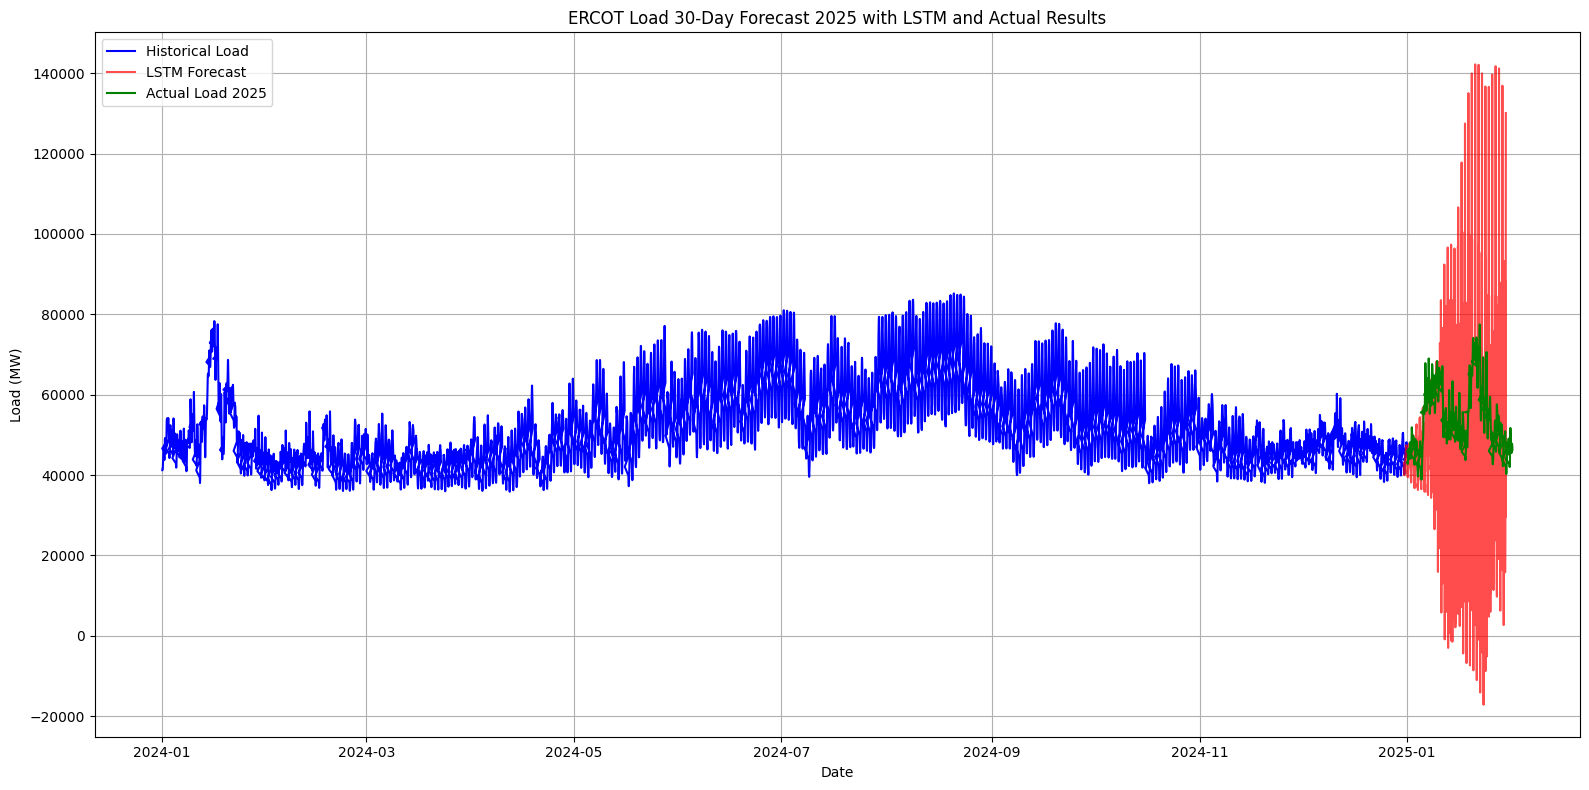

In [12]:
# Plot results
plt.figure(figsize=(16,8))
plt.plot(df.index, df['ERCOT'], label='Historical Load', color='blue')
plt.plot(forecast_dates, forecast_ercot, label='LSTM Forecast', color='red', alpha=0.7)
plt.plot(df2.index, df2['ERCOT'], label='Actual Load 2025', color='green')
plt.title('ERCOT Load 30-Day Forecast 2025 with LSTM and Actual Results')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Calculate confidence intervals (assuming a fixed percentage for simplicity)
confidence_interval = 0.1  # 10% confidence interval
forecast_upper = forecast_ercot * (1 + confidence_interval)
forecast_lower = forecast_ercot * (1 - confidence_interval)

# Create subplots
fig = make_subplots(rows=1, cols=1)

# Add historical load trace
fig.add_trace(go.Scatter(x=df.index, y=df['ERCOT'], mode='lines', name='Historical Load', line=dict(color='blue')), row=1, col=1)

# Add forecast trace
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_ercot, mode='lines', name='LSTM Forecast', line=dict(color='red', dash='dash')), row=1, col=1)

# Add confidence interval
fig.add_trace(go.Scatter(x=np.concatenate([forecast_dates, forecast_dates[::-1]]),
                         y=np.concatenate([forecast_upper, forecast_lower[::-1]]),
                         fill='toself',
                         fillcolor='rgba(255, 0, 0, 0.2)',
                         line=dict(color='rgba(255, 255, 255, 0)'),
                         hoverinfo="skip",
                         showlegend=False), row=1, col=1)

# Add actual results trace from df2
fig.add_trace(go.Scatter(x=df2.index, y=df2['ERCOT'], mode='lines', name='Actual Load 2025', line=dict(color='green')), row=1, col=1)

# Update layout
fig.update_layout(title='ERCOT Load 30-Day Forecast 2025 with LSTM and Actual Results',
                  xaxis_title='Date',
                  yaxis_title='Load (MW)',
                  legend=dict(x=0, y=1),
                  template='plotly_white')

# Show plot
fig.show()

# Save plot as HTML
fig.write_html("ercot_load_forecast_with_actual_results.html")